# Recommendation Systems Assignment

### MIE451/1513 UofT

### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [ ]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users in rating df:", num_users)
print("Number of items in rating df:", num_items)
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    
    ###########         end         ###########
    return matrix

In [ ]:
dataPreprocessor(rating_df_train, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]
                
                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # # report progress every 100 users
            # if (user % 100 == 0 and item == 1):
            #     print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # # report progress every 100 users
            # if (user % 100 == 0 and item == 1):
            #     print ("calculated %d users" % (user,))
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df_train, num_users, num_items)

In [ ]:
x = popularity_recsys.getModel()

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3116.48it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df_train, num_users, num_items)

In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3107.83it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1/(1+similarity_matrix)
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = pairwise_distances(matrix, metric='manhattan')
        similarity_matrix = 1/(1+similarity_matrix)
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########

            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)

            normalizer = np.matmul(uu_similarity, temp_matrix)

            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0

            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            train_matrix = train_matrix.T
             # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)

            normalizer = np.matmul(ii_similarity, temp_matrix)

            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0

            #Cold start
            # if no one has rated this item before, use user average  
            itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.T

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

### (b)

I chose to use Manhattan Metric. It measures the total difference betweene X and Y coordinates, which is kinda similar to euclidean distance. it is a good metric because it is appropriate if different dimension are not comparable as well as it focus less on outliers.

## Q3

### (a)

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df_train, num_users, num_items)

In [ ]:
user_cosine_recsys.getModel()

array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:06, 3115.10it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


### (b)

In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:06, 3108.85it/s]
20000it [00:06, 3035.24it/s]
20000it [00:06, 3103.24it/s]
20000it [00:06, 3157.80it/s]
20000it [00:06, 3116.66it/s]


Processing algorithm useraverage


20000it [00:06, 3105.21it/s]
20000it [00:06, 3096.67it/s]
20000it [00:06, 2918.22it/s]
20000it [00:06, 3114.76it/s]
20000it [00:06, 3086.09it/s]


Processing algorithm user-cosine


20000it [00:06, 3084.67it/s]
20000it [00:06, 3083.43it/s]
20000it [00:06, 3047.00it/s]
20000it [00:06, 3017.06it/s]
20000it [00:06, 2935.49it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [ ]:
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]
cv_rmse = CrossValidation('RMSE')
rmse_result = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)


Processing algorithm user-cosine


20000it [00:06, 2993.08it/s]
20000it [00:06, 3034.80it/s]
20000it [00:06, 3049.32it/s]
20000it [00:06, 3064.69it/s]
20000it [00:06, 3036.95it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3063.93it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3023.48it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3068.47it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3047.38it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3033.12it/s]


In [ ]:
print('\t\tMetric: RMSE')
print('Method\t\tMean\t\t\tCI')
for metric in rmse_result:
    print('{}\t{}\t{}\t{}'.format(metric,rmse_result.get(metric)[1],rmse_result.get(metric)[2],rmse_result.get(metric)[3]))

		Metric: RMSE
Method		Mean			CI
user-cosine	1.0173541216605808	1.009013080226148	1.0256951630950135
item-cosine	1.020082900106248	1.0068242686250732	1.0333415315874226


The results are pretty similar

## Q4

### (a)

In [ ]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########

        self.w_Item = np.random.normal(0,0.1,(num_item,self.num_feat)) # item M x D 
        self.w_User = np.random.normal(0,0.1,(num_user,self.num_feat))  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
                


                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1) #size (batch_size, )
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :],
                                                  self.w_Item[train_item_idx, :]),
                                      axis=1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :],
                                                  self.w_Item[val_item_idx, :]),
                                      axis=1)  #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

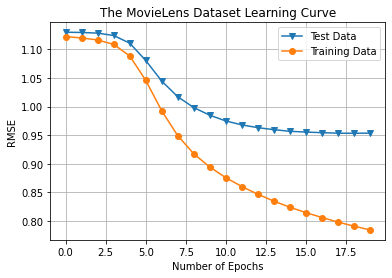

In [ ]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 10, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

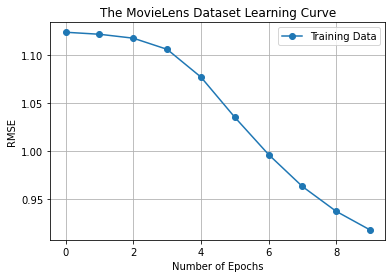

In [ ]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

To avoid overfitting, i changed maxepoch to 10, where the test curve slowly converge, but the training curve still drops dramatically

## Q5

### (a)

In [ ]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]
                       
metrics = ['RMSE','P@K', 'RPrecision']
cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_rpre = CrossValidation('RPrecision')


rmse_result = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)
patk_result = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
rpre_result = cv_rpre.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:06, 3039.26it/s]
20000it [00:06, 3195.35it/s]
20000it [00:06, 3057.05it/s]
20000it [00:06, 3100.03it/s]
20000it [00:06, 3085.95it/s]


Processing algorithm useraverage


20000it [00:06, 3081.84it/s]
20000it [00:07, 2817.89it/s]
20000it [00:06, 3043.01it/s]
20000it [00:06, 3121.74it/s]
20000it [00:07, 2794.60it/s]


Processing algorithm user-cosine


20000it [00:06, 3063.67it/s]
20000it [00:06, 3079.31it/s]
20000it [00:06, 3054.47it/s]
20000it [00:06, 3124.17it/s]
20000it [00:06, 3027.32it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3066.44it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3064.07it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3060.18it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3080.83it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3092.17it/s]


Processing algorithm PMF


20000it [00:14, 1410.08it/s]
20000it [00:12, 1665.07it/s]
20000it [00:11, 1670.01it/s]
20000it [00:11, 1696.58it/s]
20000it [00:12, 1641.52it/s]


Processing algorithm popularity


20000it [00:06, 3085.06it/s]
20000it [00:06, 3083.40it/s]
20000it [00:06, 3115.05it/s]
20000it [00:06, 2932.59it/s]
20000it [00:06, 2893.06it/s]


Processing algorithm useraverage


20000it [00:06, 3123.76it/s]
20000it [00:06, 3120.71it/s]
20000it [00:06, 3156.66it/s]
20000it [00:06, 3130.73it/s]
20000it [00:06, 3121.04it/s]


Processing algorithm user-cosine


20000it [00:06, 3084.28it/s]
20000it [00:06, 3092.90it/s]
20000it [00:06, 3048.53it/s]
20000it [00:06, 3087.87it/s]
20000it [00:06, 3085.17it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3096.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3106.58it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3057.17it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3055.85it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3087.31it/s]


Processing algorithm PMF


20000it [00:11, 1683.17it/s]
20000it [00:11, 1676.14it/s]
20000it [00:12, 1650.77it/s]
20000it [00:11, 1675.13it/s]
20000it [00:11, 1693.59it/s]


Processing algorithm popularity


20000it [00:06, 3074.30it/s]
20000it [00:06, 3078.49it/s]
20000it [00:06, 2888.91it/s]
20000it [00:06, 3061.20it/s]
20000it [00:06, 3090.85it/s]


Processing algorithm useraverage


20000it [00:06, 3077.55it/s]
20000it [00:06, 3120.08it/s]
20000it [00:06, 3075.74it/s]
20000it [00:06, 3093.43it/s]
20000it [00:06, 3058.21it/s]


Processing algorithm user-cosine


20000it [00:06, 3091.83it/s]
20000it [00:06, 2866.91it/s]
20000it [00:06, 2857.93it/s]
20000it [00:06, 3072.27it/s]
20000it [00:06, 3041.55it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3062.14it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3040.42it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3042.32it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3021.03it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3036.62it/s]


Processing algorithm PMF


20000it [00:12, 1565.30it/s]
20000it [00:12, 1641.77it/s]
20000it [00:12, 1641.28it/s]
20000it [00:11, 1669.64it/s]
20000it [00:12, 1559.08it/s]


### (b)

In [ ]:
print('\t\tMetric: RMSE')
print('Method\t\tMean\t\t\tCI')
for metric in rmse_result:
    print('{}\t{}\t{}\t{}'.format(metric,rmse_result.get(metric)[1],rmse_result.get(metric)[2],rmse_result.get(metric)[3]))
print('\t\tMetric: P@K')
print('Method\t\tMean\t\t\tCI')
for metric in patk_result:
    print('{}\t{}\t{}\t{}'.format(metric,patk_result.get(metric)[1],patk_result.get(metric)[2],patk_result.get(metric)[3]))
print('\t\tMetric: R@K')
print('Method\t\tMean\t\t\tCI')
for metric in rpre_result:
    print('{}\t{}\t{}\t{}'.format(metric,rpre_result.get(metric)[1],rpre_result.get(metric)[2],rpre_result.get(metric)[3]))

		Metric: RMSE
Method		Mean			CI
popularity	3.1590928909890112	3.139292746995387	3.1788930349826354
useraverage	1.0437176561595025	1.0289303496379316	1.0585049626810734
user-cosine	1.0173541216605808	1.009013080226148	1.0256951630950135
item-cosine	1.020082900106248	1.0068242686250732	1.0333415315874226
PMF	0.9761061172578716	0.9595885632326167	0.9926236712831265
		Metric: P@K
Method		Mean			CI
popularity	0.5505832449628855	0.40544114481568705	0.6957253451100839
useraverage	0.4736373276776259	0.3419993013451059	0.6052753540101459
user-cosine	0.5558430540827157	0.40959849499983714	0.7020876131655943
item-cosine	0.5322163308589621	0.3837005215009889	0.6807321402169354
PMF	0.5509650053022277	0.4064771339642145	0.6954528766402409
		Metric: R@K
Method		Mean			CI
popularity	0.7176664506052826	0.7068236314882174	0.7285092697223478
useraverage	0.6457304920247127	0.6396305850946756	0.6518303989547497
user-cosine	0.7210187903610459	0.7099951520220996	0.7320424286999921
item-cosine	0.708014242363

RMSE cannot be used for popularity recommender, because the popularity prediciton range is 0 to 1.
if you calculate the MSE between predcition and test set, you will get a large error compare to other methods. 

for RMSE, PMF performed the best

for P@K, user-cosine is better

for Rprecision, user-cosine is also better


not really, for example, popularity recommender cannot be measured by RMSE, the ranking of RMSE is not reflective in that case

## Q6

### (a)

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

Matrix_Q6 = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(Matrix_Q6.T)

def top5Sim(sim, movieID, movieName):
    top5_index = np.argsort(sim[movieID-1])[::-1][1:6]
    top5 = list(map(lambda x: moviesDF[moviesDF.movieID ==x+1]['movieTitle'].values[0],top5_index))
    print('5 Most similar movies of {} are {} \n'.format(movieName,top5))
top5Sim(ii_similarity, 5, "Copycat")
top5Sim(ii_similarity,500, "Fly Away Home")
top5Sim(ii_similarity, 103, "All Dogs Go to Heaven 2")

5 Most similar movies of Copycat are ['Cape Fear (1991)', 'Nightmare on Elm Street, A (1984)', 'Outbreak (1995)', 'Jaws (1975)', 'Natural Born Killers (1994)'] 

5 Most similar movies of Fly Away Home are ['Fly Away Home (1996)', 'Dear God (1996)', 'Babe (1995)', 'Everest (1998)', 'When a Man Loves a Woman (1994)'] 

5 Most similar movies of All Dogs Go to Heaven 2 are ['Everest (1998)', 'Flipper (1996)', 'Wedding Gift, The (1994)', 'Assassins (1995)', 'Unforgettable (1996)'] 



### (b)

Yes, because for each movie i picked, the returned top 5 movies belong to the same categories. 

## Q7

### (a)

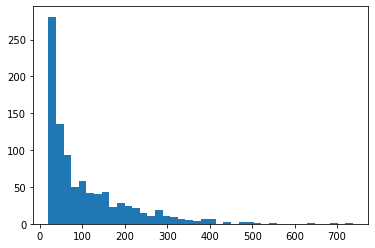

In [ ]:
import matplotlib.pyplot as plt
Matrix_Q7 = dataPreprocessor(rating_df, num_users, num_items)
ratesperuser = np.count_nonzero(Matrix_Q7, axis=1)
plt.hist(ratesperuser, bins =40)
plt.show()

Lets choose threshold at 75

In [ ]:
#All copied from previous section
def cos_rec(train_matrix, base):
    if base == 'user':
        ########### your code goes here ###########
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        normalizer = np.matmul(uu_similarity, temp_matrix)
        normalizer[normalizer==0] =1e-5
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer


        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1))
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        return predictionMatrix


    elif base == 'item':
        ########### your code goes here ###########
        train_matrix = train_matrix.T
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer==0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

        itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1))
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)


        return predictionMatrix.T

def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [ ]:
above75 = Matrix_Q7[np.count_nonzero(Matrix_Q7, axis=1) >=75]
below75 = Matrix_Q7[np.count_nonzero(Matrix_Q7, axis=1) <75]

above75U_pred = cos_rec(above75, 'user')
below75U_pred = cos_rec(below75, 'user')
above75I_pred = cos_rec(above75, 'item')
below75I_pred = cos_rec(below75, 'item')
rmse_Uabove = rmse(above75U_pred,above75)
rmse_Ubelow = rmse(below75U_pred,below75)
rmse_Iabove = rmse(above75I_pred,above75)
rmse_Ibelow = rmse(below75I_pred,below75)
print(rmse_Uabove,
      rmse_Ubelow,
      rmse_Iabove,
      rmse_Ibelow)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


0.9475850378208265 0.8826026173996676 0.9908554841643358 0.8835152990086254


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


the group with user who rated below 75 performed better in both uu and ii similarity filtering. the reason why they performed better is because that with fewer ratings, they are more focused than users with larger ratings, which made the recommendation systems eaiser to predict for the users with fewer ratings. 

## Q8

In [ ]:
class CompetitionRecSys(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self, ):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give  to your competition method
        
        """
        ########## your code goes here ###########
        self.pred_column_name = 'IDK'
        ###########         end         ###########

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        """     
        ########## your code goes here ###########

        train_matrix = dataPreprocessor(train_vec, num_user, num_item)   
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')

        normalizer = np.matmul(uu_similarity, temp_matrix)

        normalizer[normalizer == 0] = 1e-5
        #what's the dimension of np.matmul(uu_similarity, trainSet)
        
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
        #predictionMatrix[temp_matrix.nonzero()] = 0

        #Cold start
        # if no one has rated this item before, use user average  
        useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
        columns = np.sum(predictionMatrix, axis=0)
        #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        self.__model = predictionMatrix

        ###########         end         ###########

        
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            ########### your code goes here ###########
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1] 
            ###########         end         ###########

        return prediction
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        ########### your code goes here ###########
        self.__model = None
        ##########         end         ###########


In [ ]:
competition = CompetitionRecSys()
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances, num_users, num_items)

Processing algorithm IDK


20000it [00:06, 2964.74it/s]
20000it [00:06, 3021.72it/s]
20000it [00:06, 2998.65it/s]
20000it [00:06, 2974.94it/s]
20000it [00:06, 2927.16it/s]


In [ ]:
print(rp)

{'IDK': [[0.7177834541075783, 0.7127674206396806, 0.7152791599993573, 0.7243681832929256, 0.7348957337656873], 0.7210187903610459, 0.7099951520220996, 0.7320424286999921]}


# Validation

In [ ]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validatePopularityRecSys()

### User Average Based Recommendation

In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [ ]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [ ]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [ ]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [ ]:
validatePMFRecSys(validation_df=validation_df)